In [549]:
import numpy as np
from numpy import array
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler

# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout, TimeDistributed

#RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

In [550]:
#load data
data = pd.read_csv('D:/NLP Course/SMA/NESTLE Dec 2015-2020.csv')
#inverse the data - start from past to present
data = data.iloc[::-1]

In [551]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1238 entries, 1237 to 0
Data columns (total 13 columns):
Date                         1238 non-null object
Open Price                   1238 non-null float64
High Price                   1238 non-null float64
Low Price                    1238 non-null float64
Close Price                  1238 non-null float64
WAP                          1238 non-null float64
No.of Shares                 1238 non-null int64
No. of Trades                1238 non-null int64
Total Turnover (Rs.)         1238 non-null int64
Deliverable Quantity         1238 non-null int64
% Deli. Qty to Traded Qty    1238 non-null float64
Spread High-Low              1238 non-null float64
Spread Close-Open            1238 non-null float64
dtypes: float64(8), int64(4), object(1)
memory usage: 125.8+ KB


In [552]:
#Convert it to datetime from object
data['Date']= pd.to_datetime(data.Date)
data.head(1)

,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
1237,2015-12-14,5900.0,5900.0,5787.2,5864.85,5837.892741,2769,870,16165125,958,34.6,112.8,-35.15


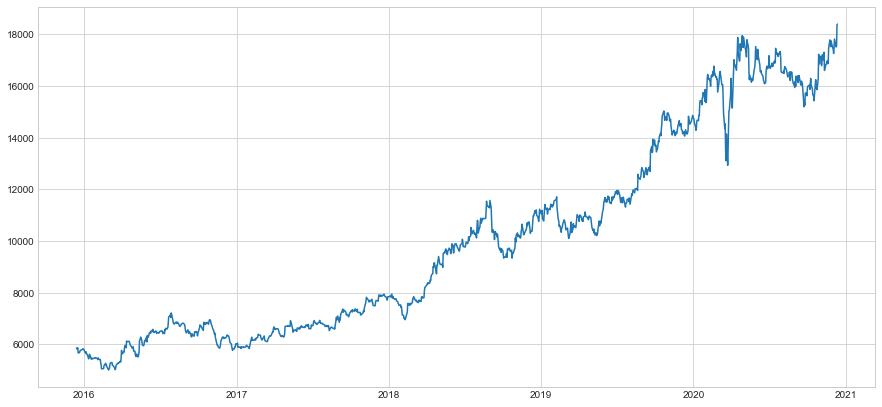

In [553]:
# Plot the price of the asset over time
plt.figure(figsize=(15,7))
plt.plot(data['Date'],data['Close Price'])

In [554]:
#Lets focus on closinf price as model parameter in timeseries
df=data.reset_index()['Close Price']

In [555]:
df.head(5)

0    5864.85
1    5830.30
2    5820.65
3    5870.30
4    5675.85
Name: Close Price, dtype: float64

In [556]:
#scale it down fro  0-1, RNN works better with smaller numbers
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [557]:
#check few samples
df[0:5]

array([[0.06366383],
       [0.06108367],
       [0.06036301],
       [0.06407083],
       [0.0495495 ]])

In [558]:
#splitting dataset into train and test split
training_size = int(len(df)*0.85)
test_size =     len(df)-training_size

train_data,test_data = df[0:training_size,:], df[training_size:len(df),:1]

In [559]:
training_size

1052

In [560]:
test_size

186

In [561]:
# LSTM input is a three dimensional vector i.e. n_samples x timesteps x n_features

def create_rnn_dataset(dataset, time_step=1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]    
        data_X.append(a)
        data_Y.append(dataset[i + time_step, 0])
    return np.array(data_X), np.array(data_Y)

In [562]:
# get a time series of data covariates x lags x timestep
timestep = 100

X_train, y_train = create_rnn_dataset(train_data, timestep)
X_test, ytest    = create_rnn_dataset(test_data, timestep)

In [563]:
print(X_train.shape), print(y_train.shape)

(951, 100)
(951,)


(None, None)

In [564]:
print(X_test.shape), print(ytest.shape)

(85, 100)
(85,)


(None, None)

In [565]:
# LSTM format of input - reshape input to be [n_samples x timesteps x n_features]
n_features = 1               #only onefeature - Close Price
n_samples = X_train.shape[0] # number of rows - 951
timesteps = X_train.shape[1] # number of columns - 100

X_train = X_train.reshape(n_samples, timesteps, n_features)

n_samples = X_test.shape[0]
timesteps = X_test.shape[1]

X_test  = X_test.reshape(n_samples, timesteps, n_features)

In [586]:
#Build a model

input_cell = 50
inner_cell = 75

model=Sequential()
model.add(LSTM(input_cell,return_sequences=True,input_shape=(timestep,n_features)))
model.add(LSTM(inner_cell,return_sequences=True))
model.add(LSTM(inner_cell))
model.add(Dense(n_features))
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['acc'])

In [567]:
#lets see how model looks like
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_123 (LSTM)              (None, 100, 50)           10400     
_________________________________________________________________
lstm_124 (LSTM)              (None, 100, 75)           37800     
_________________________________________________________________
lstm_125 (LSTM)              (None, 75)                45300     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 76        
Total params: 93,576
Trainable params: 93,576
Non-trainable params: 0
_________________________________________________________________


In [568]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Train on 951 samples, validate on 85 samples
Epoch 1/100
951/951 [==============================] - 15s 16ms/sample - loss: 0.0357 - acc: 0.0000e+00 - val_loss: 0.0771 - val_acc: 0.0000e+00
Epoch 2/100
951/951 [==============================] - 8s 8ms/sample - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.0117 - val_acc: 0.0000e+00
Epoch 3/100
951/951 [==============================] - 6s 7ms/sample - loss: 0.0014 - acc: 0.0000e+00 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 4/100
951/951 [==============================] - 6s 7ms/sample - loss: 8.3213e-04 - acc: 0.0000e+00 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 5/100
951/951 [==============================] - 6s 7ms/sample - loss: 7.0644e-04 - acc: 0.0000e+00 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 6/100
951/951 [==============================] - 11s 12ms/sample - loss: 6.8112e-04 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 7/100
951/951 [==============================] - 8s 8ms/sample - loss: 6.68

Epoch 56/100
951/951 [==============================] - 6s 6ms/sample - loss: 3.7741e-04 - acc: 0.0000e+00 - val_loss: 9.8389e-04 - val_acc: 0.0000e+00
Epoch 57/100
951/951 [==============================] - 7s 7ms/sample - loss: 3.6435e-04 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 58/100
951/951 [==============================] - 7s 7ms/sample - loss: 3.8264e-04 - acc: 0.0000e+00 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 59/100
951/951 [==============================] - 8s 9ms/sample - loss: 3.7847e-04 - acc: 0.0000e+00 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 60/100
951/951 [==============================] - 7s 7ms/sample - loss: 3.6168e-04 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 61/100
951/951 [==============================] - 6s 7ms/sample - loss: 3.8103e-04 - acc: 0.0000e+00 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 62/100
951/951 [==============================] - 7s 7ms/sample - loss: 4.4063e-04 - acc: 0.0000e+00 -

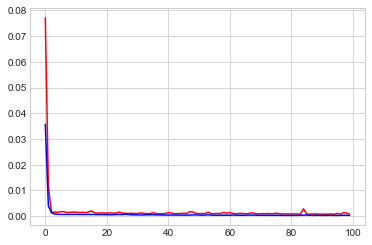

In [569]:
plt.plot(history.history['val_loss'], 'r')
plt.plot(history.history['loss'], 'b')

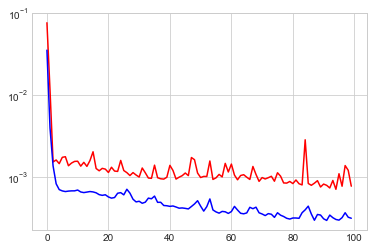

In [570]:
plt.semilogy(history.history['val_loss'], 'r')
plt.semilogy(history.history['loss'], 'b')

In [571]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

#Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [572]:
rmse = np.sqrt(np.mean(y_train-train_predict)**2)
rmse

9296.46066071064

In [573]:
rmse = np.sqrt(np.mean(ytest - test_predict)**2)
rmse

16363.118447509703

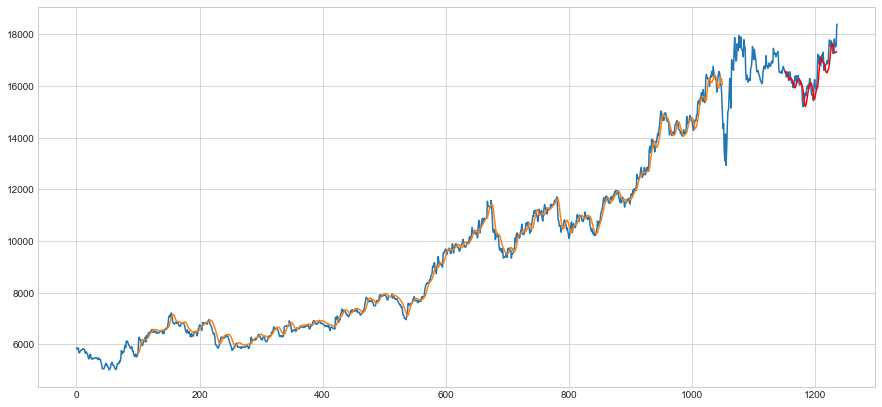

In [574]:
### Plotting 
# shift train predictions for plotting
look_back=timestep

trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize=(15,7))
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot, color = 'r')
plt.show()

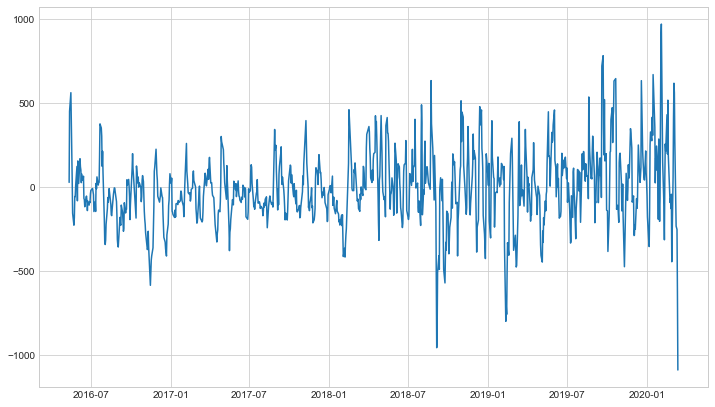

In [575]:
# plot residual erros between baseline and predictions
plt.figure(figsize=(12,7))
plt.plot(data['Date'],scaler.inverse_transform(df)-trainPredictPlot)
plt.show()

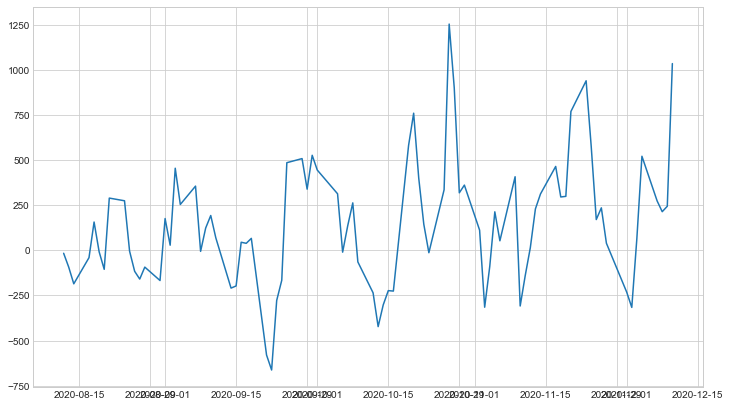

In [576]:
# plot residual erros between baseline and predictions
plt.figure(figsize=(12,7))
plt.plot(data['Date'],scaler.inverse_transform(df)-testPredictPlot)
plt.show()

In [577]:
len(test_data)

186

In [578]:
#248-75 - 173: take last 75 records from test data
indx = len(test_data) - timestep

x_input=test_data[indx:].reshape(1,-1)
x_input.shape

(1, 100)

In [579]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

print(len(temp_input))
temp_input[0:3]

100


[0.9146494008879328, 0.9125061143409768, 0.9209074988891502]

In [580]:
# demonstrate prediction for next 30 days
# Take last 100 records from test data and use it for prediction for next day and add that to list and reset the index 
#to t+1 and iterate for next 29 days.
#Examples data is 1,2,3,4,5 with timestep = 3 then start with 3,4,5 and add the predicted value to list as 3,4,5,p1 and 
#then iterate with another samples of 4,5,p1 and predict p2 and add to list and so on....

from numpy import array

lst_output=[]
n_steps=timestep
i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input.shape
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

[0.9504246]
101


In [581]:
len(df)

1238

In [582]:
day_new=np.arange(1,timestep+1)
day_pred=np.arange(timestep+1,timestep+1+30)

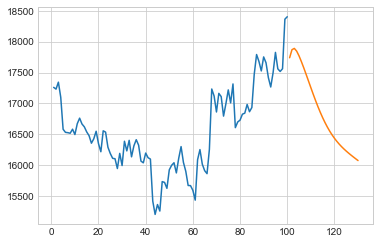

In [583]:
#1238-100 = 1138
#plot the data for last 75 days
plt.plot(day_new,scaler.inverse_transform(df[len(df)-timestep:]))
#Add the predicted data for next 30 days 
plt.plot(day_pred,scaler.inverse_transform(lst_output))

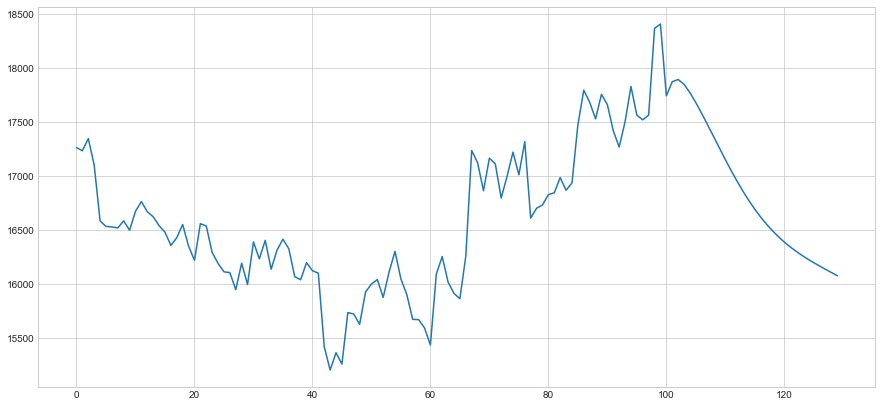

In [588]:
df1=df.tolist() 
df1.extend(lst_output)
df1=scaler.inverse_transform(df1).tolist()

plt.figure(figsize=(15,7))
plt.plot(df1[1138:])